# Customer Churn Study
* Publish date: 7 Apr, 2020
* Author: Tommy Lam
* Data source: https://www.kaggle.com/blastchar/telco-customer-churn

Customer Churn, also known as customer attrition and customer turnover, refers to the loss of the customer.

Many competitive contract-based services such as internet and telephone providers, banking, TV and insurance often use this analysis to study and predict the behaviour of customers such that they can develop strategies to retain their customers.


# Objective
This project studies the customer churn based on the services they have signed up, customer account information and their demographic. The first objective of this project is to investigate which factors give the most impact on customer churn. The second objective is to predict whether the customer would quit the service based on various models.

# Data Source
The dataset used in this project is from Kaggle. The dataset includes 4 types of information:
1. Customers who left within the last month
2. Services that customers have signed up for including phone, multiple lines, internet, etc.
3. Customer account information including contract status, payment method, monthly charges and total charges.

## Import libraries
Here are all the libraries used in this study.

In [162]:
# data manipunation
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

# data wrangling
from sklearn.preprocessing import LabelBinarizer

# data modelling
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# miscellous
import warnings

## Import data

In [163]:
data = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.shape

(7043, 21)

In [164]:
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


# Exploratory Data Analysis
Exploratory data analysis (EDA) is an approach to analysing data sets to summarise their main characteristics with visual methods. It is generally used as a primary mean to research and investigate the dataset, before performing advanced modelling.


Since there are some null values in 'Total Charges', which makes this column unavailable to be analysed as a numeric value. Therefore, those null values will be converted into 0.

In [165]:
data.TotalCharges = data.TotalCharges.apply(lambda x: 0 if x == ' ' else float(x)  )

Columns with numeric values can be understood easily by using the describe function. Basic statistics information including counts, mean, std and quantiles are provided in the table.

In [166]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Categorical data can be also summarised by describe function with argument 'include=['O']'.

In [167]:
data.describe(include=['O'])

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,9134-WYRVP,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,5174


### Numeric Data
Boxplot is one of the good approaches to understand numeric data since it provides the information of range, median, quantiles and distribution.

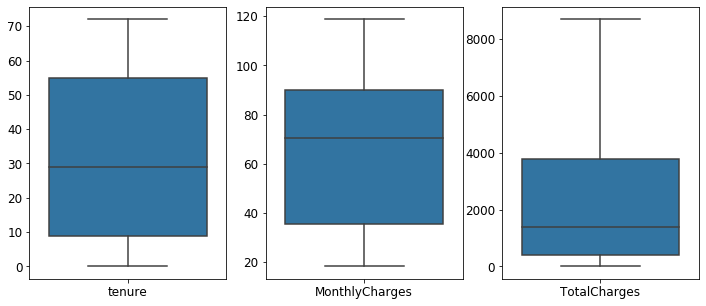

In [168]:
plt.figure(figsize=(12,5))  

plt.subplot(1, 3, 1)
sns.boxplot(data=data[['tenure']], orient="v")

plt.subplot(1, 3, 2)
sns.boxplot(data=data[['MonthlyCharges']], orient="v")

plt.subplot(1, 3, 3)
sns.boxplot(data=data[['TotalCharges']], orient="v")

plt.show()

### Categorical Data
Now let's produce some charts to visualise the data. Since most of the categorical values contain only a few distinct values, we will use donut charts to visualise their patterns.

First we can create a function to generate donut chart to simplify the codes. Donut chart is basically composed of a pie chart and white hole on top of it.

In [169]:
# define a function to produce donut chart with formatting
def donut_chart (data_series) :
    check = data_series.unique()
    count = list()
    
    # convert the data into charting ready format
    for each in check:
        count.append(sum(data_series == each))
        
    # donut hole drawing
    donut_hole = plt.Circle( (0,0), 0.7, color='white')
    
    # pie chart drawing
    plt.pie(count, 
            labels=list(check),autopct='%1.1f%%', # data style
            shadow=True, startangle=90) # chart formatting
    plt.title(data_series.name)
    p=plt.gcf()
    return p.gca().add_artist(donut_hole)

The variable SeniorCitizen appears to be a numeric column while we check the summary table above. However, it only consists of two values, 0 and 1, identifying whether the customer is a senior citizen or not. Therefore, it actually is a categorical variable and can be visualised by a donut chart.

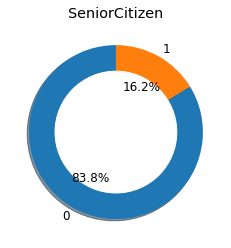

In [170]:
donut_chart(data.SeniorCitizen)

The following donut charts show the pattern of the rest of the categorical variables. 

We can see the gender split is half-half, similar to the partnership. For the contract status, more than half of the customers are in a month to month contract, which is considered as a highly correlated factor driving customer churn in the next part.

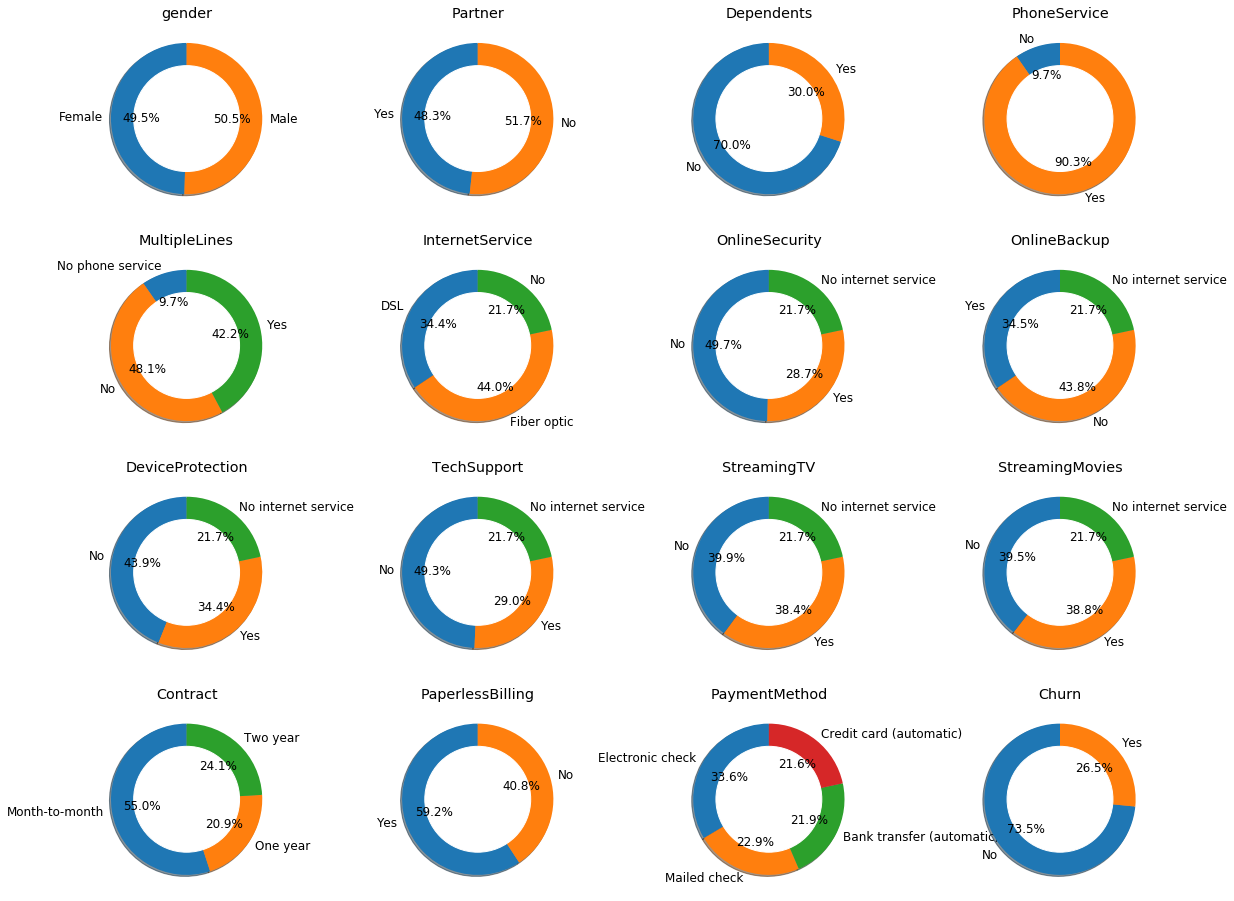

In [171]:
plt.figure(figsize=(20,16))    

for i in range(1,17):
    plt.subplot(4, 4, i)
    donut_chart(data[data.describe(include=['O']).columns[i]])

# Data Wrangling/ Preprocessing
Before we run the models over the dataset, we need to convert those categorical data into a machine-readable format. In this section, we will use label binarizer to convert the categorical data into numeric data. For example, a column of [a,b,b,a] would become [a: 1,0,0,1 ; b: 0,1,1,0]. In this way, we are able to pass the categorical information into models for further analysis.

In [172]:
from sklearn.preprocessing import LabelBinarizer

## for yes-no only variable
def yes_no(data,column):
    return data[column].apply(lambda x: 1 if x == 'Yes' else 0)

## for more than just yes-no
def binarize(data,column):
    binarize = LabelBinarizer()
    lb_results = binarize.fit_transform(data[column])
    return pd.DataFrame(lb_results, columns=[column+ '_' + each for each in binarize.classes_])


In [173]:
categorical_columns = data.iloc[:,2:].describe(include=['O']).columns

In [174]:
numeric_columns = data.describe().columns

In [175]:
data_processed = data[numeric_columns]
# data_processed.head(1)

In [176]:
for each in categorical_columns:
    if set(data[each].unique()) == {'Yes','No'}: 
        data_processed = pd.concat([data_processed,yes_no(data,each)],axis = 1)
    else:
        data_processed = pd.concat([data_processed,binarize(data,each)],axis = 1)

In [177]:
data_processed.head(3)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Partner,Dependents,PhoneService,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,29.85,29.85,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
1,0,34,56.95,1889.50,0,0,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0,2,53.85,108.15,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,1,1


## Correlation Matrix
We can easily build a correlation matrix since the preprocessed data are all in numeric values. 

One of the methods to visualise the correlation matrix is by using a heatmap. The following heatmap from seaborn library displays the relationship between variables.

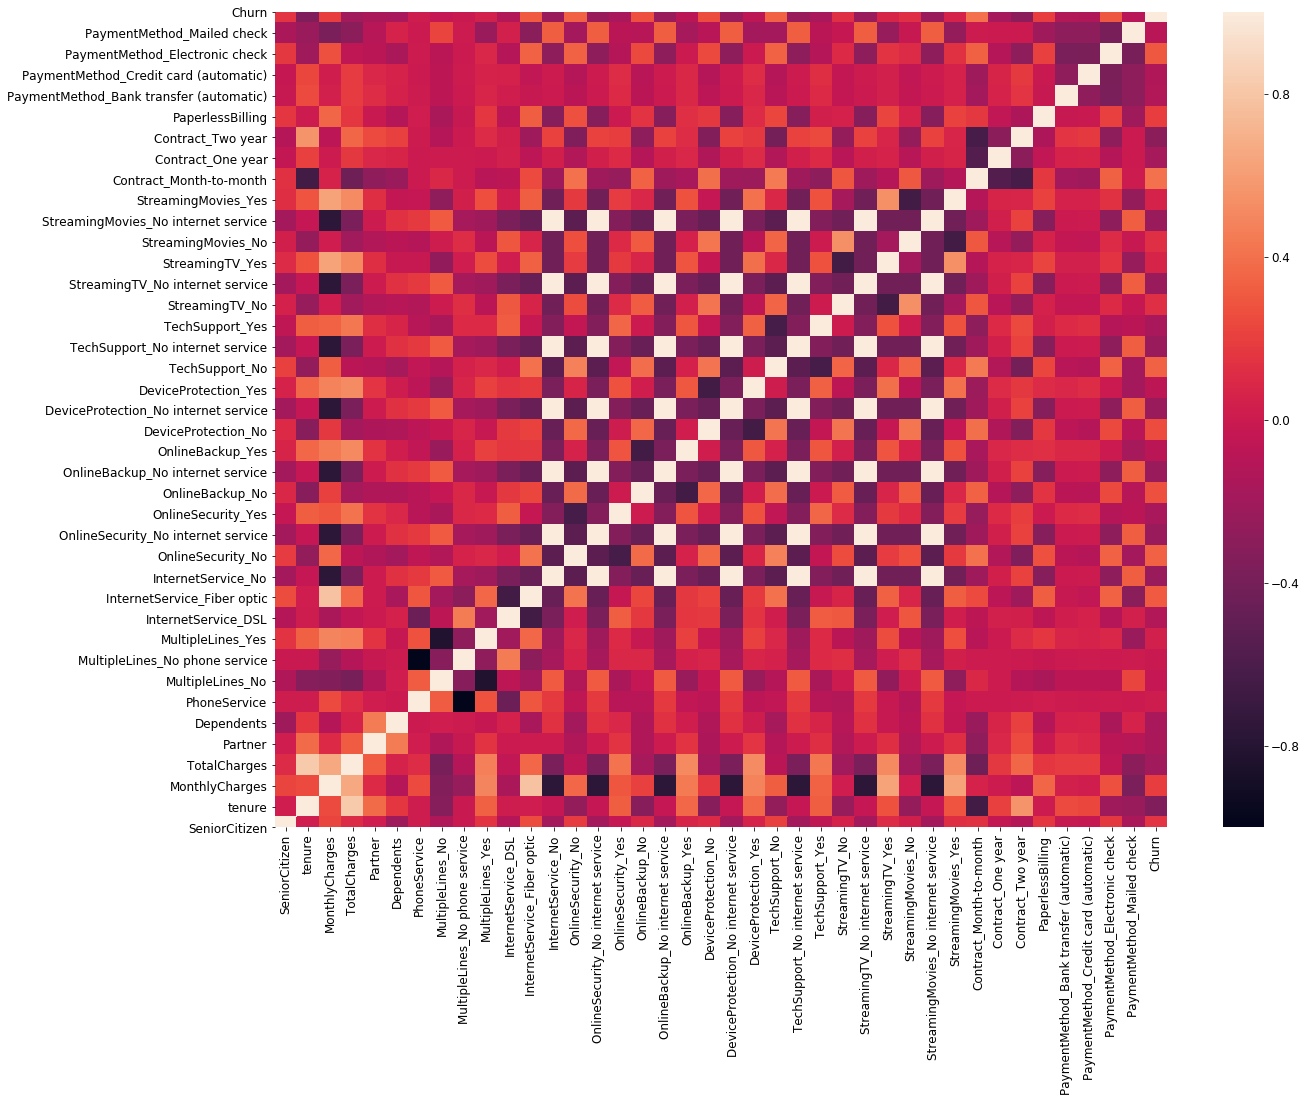

In [178]:
corr_plot = data_processed.corr()
plt.figure(figsize=(20,15))
plt.rcParams.update({'font.size': 12})
sns.heatmap(corr_plot.reindex(index=corr_plot.index[::-1]))

However, it is not an easy task to read the correlation heatmap when the amount of variables is considerably large. Instead, we can simply look at the top correlated variables to our target variable, 'Churn' in a bar chart.

In [179]:
corr_table = data_processed.corr()['Churn'].apply(abs).sort_values(ascending = False)

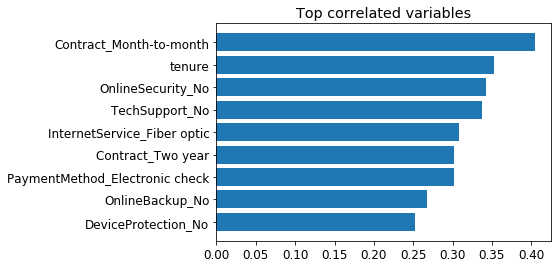

In [180]:
plt.barh(corr_table.index[1:10],corr_table[1:10])
plt.title('Top correlated variables')
plt.gca().invert_yaxis()

We can observe that the top factor relating to Churning is when the customer is under a month to month contract. This is understandable since contracts in month to month have the highest flexibility hence they are easier for customers to turn down and switch to other providers.

The second relating factor would be 'tenure', which is representing the number of months the customer has stayed with the company. When we check the relationship of this variable against churn from the heatmap or correlation table, we can find that it is negatively correlated to the churn. This is also easy to explain the story that customers with larger 'tenure' values mean they are having more stable jobs, hence they also tends to stay in their telecom service.

# Training and Testing data
Before we train the model, the data is divided into a training set and testing set in a ratio of 80:20. The training set will be used to train the models to predict the customer churn, while the testing set is for us to validate the performance of the models trained from the training set.

In [181]:
len(data_processed)

7043

In [182]:
Total_length = len(data_processed)
Train_ratio = 0.8

train_data = data_processed.iloc[0:int(Total_length*Train_ratio),:]
testing_data = data_processed.iloc[int(Total_length*Train_ratio):,:]

# Logistic Regression
The first predictive model we use is logistic regression. Logistic regression is trained in a similar way as linear regression, using the factors as input in a regression equation to calculate the output (Output ~ factor_1 + factor_2 + ...).

However, we will pass the output from the regression equation into a sigmoid function, which makes the result bounds between 0 to 1. This allows us to perform classification when we set a boundary so that all values below the boundary are categorised as 0 and the rest will be as 1.

In [183]:
from sklearn.linear_model import LogisticRegression

x_train = train_data.iloc[:,0:-1]
y_train = train_data.iloc[:,-1]
x_test = testing_data.iloc[:,0:-1]

In [184]:
# For small datasets, ‘liblinear’ is a good choice. ‘liblinear’ is limited to one-versus-rest schemes. 
# It also handles L1 penalty
LR = LogisticRegression(solver = 'liblinear').fit(x_train, y_train)

In [185]:
y_test = testing_data.iloc[:,-1]
LR_pred_train = LR.predict(x_train)
LR_pred_test = LR.predict(x_test)

In [186]:
from sklearn.metrics import classification_report
target_names = ['No', 'Yes']
print(classification_report(y_test, LR_pred_test, target_names=target_names))

              precision    recall  f1-score   support

          No       0.84      0.91      0.87      1028
         Yes       0.68      0.53      0.59       381

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [187]:
def accuracy(a,b):
    return sum(a==b)/len(a)

In [188]:
print('Training accuracy: %.3f \nTesting  accuracy: %.3f' 
      % (accuracy(y_train, LR_pred_train),accuracy(y_test, LR_pred_test)))

Training accuracy: 0.807 
Testing  accuracy: 0.804


# SVM (Support Vector Machines)
The basic idea of Support Vector Machines is to find an optimum hyperplane to divide the dataset into two classes, as illustrated by the picture below.

![title](images/svm-demo.png)

By default, a linear hyperplane is used to divide the dataset. However, in some complicated dataset, other forms of hyperplane may be required such as polynomial hyperplane. In those cases, we will use other kernels to train the model, for example sigmoid, rbf, polynomial, etc.

In this section, we will start with the default parameters in the sklearn library (kernel: rbf).

In [189]:
from sklearn import svm

svm_model = svm.SVC()
svm_model.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [190]:
y_svm_predict = svm_model.predict(x_test)

In [191]:
print(classification_report(y_test, y_svm_predict, target_names=target_names))

              precision    recall  f1-score   support

          No       0.79      0.94      0.86      1028
         Yes       0.68      0.32      0.43       381

    accuracy                           0.78      1409
   macro avg       0.73      0.63      0.65      1409
weighted avg       0.76      0.78      0.74      1409



In [192]:
accuracy(y_test, y_svm_predict)

0.7750177430801988

It appears that 77.5% is not a good result from the default parameters of the support vector machines. Let's try some more different types of SVM to find a better model.

In [392]:
%%time
C = 1.0
models = (svm.SVC(kernel='linear', C=C),
          svm.SVC(kernel = 'poly',degree = 2),
          svm.SVC(kernel='rbf',gamma='auto',C=C),
          svm.SVC(kernel='sigmoid'))

models = list(clf.fit(x_train, y_train) for clf in models)

CPU times: user 35min 38s, sys: 50.4 s, total: 36min 28s
Wall time: 53min 22s


In [397]:
svm_predict_train = (model.predict(x_train) for model in models)
svm_predict_test = (model.predict(x_test) for model in models)

In [398]:
training_accuracy_svm = list(accuracy(y_train,each) for each in svm_predict_train)
test_accuracy_svm = list(accuracy(y_test,each) for each in svm_predict_test)

In [399]:
# title for the plots
titles = ('SVC with linear kernel',
          'SVC with polynomial kernel (degree = 2)',
          'SVC with RBF kernel (auto gamma)',
          'SVC with sigmoid kernel')

In [401]:
svc_performance = pd.DataFrame({'model':list(titles),'Training_accuracy':training_accuracy_svm,'Testing_accuracy':test_accuracy_svm})
svc_performance

,model,Training_accuracy,Testing_accuracy
0,SVC with linear kernel,0.796237,0.801987
1,SVC with polynomial kernel (degree = 2),0.766951,0.755145
2,SVC with RBF kernel (auto gamma),0.908946,0.775018
3,SVC with sigmoid kernel,0.735889,0.729595


The model spent most of the time to train the polynomial hyperplane as it carries a higher complexity. However, we can see that the SVM with linear hyperplane gives the highest testing accuracy, which indicates that the dataset itself is not structured in high complexity.

# K-nearest Neighbors Classification (KNN)
KNN is one of the famous non-parametric algorithm, which may not require any parameters to build the algorithm. It focuses on the feature similarity, which aims to find out the most similar data to perform classification or regression. 

For a simple example, if I would like to make a decision based on my body characteristics. KNN algorithm will first find out a few people with similar characteristics with me (height, weight, gender,...) and base on their decisions to predict my decision.

The image below illustrates how can we find the nearest neighbors and categorise the new item (star) as class B as two of its neighbor are in Class B.
![title](images/knn-demo.png)

Again, I will start with the default parameters in the sklearn KNN classifier (k=5).

In [365]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
neigh.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [366]:
knn_predict_train = neigh.predict(x_train)
knn_predict_test = neigh.predict(x_test)

In [382]:
print('Training accuracy: %.3f \nTesting  accuracy: %.3f' 
      % (accuracy(y_train, knn_predict_train),accuracy(y_test, knn_predict_test)))

Training accuracy: 0.831 
Testing  accuracy: 0.767


This gives 76.7% testing accuracy. Next, we can try other K values to find out the best algorithm predicting customer churn.

In [276]:
%%time
## run the KNN for different k nearest neighbors
k = []
knn_fit = []
train_accuracy = []
test_accuracy = []
for each in range(1,39):
    neigh = KNeighborsClassifier(n_neighbors=each)
    knn_fit.append(neigh.fit(x_train, y_train))
    knn_predict_train = knn_fit[-1].predict(x_train)
    knn_predict_test = neigh.predict(x_test)
    k.append(each)
    train_accuracy.append(accuracy(y_train, knn_predict_train))
    test_accuracy.append(accuracy(y_test, knn_predict_test))

CPU times: user 12.1 s, sys: 216 ms, total: 12.4 s
Wall time: 12.6 s


In [277]:
KNN_result = pd.DataFrame({'k':k,'Training_accuracy':train_accuracy,'Testing_accuracy':test_accuracy})

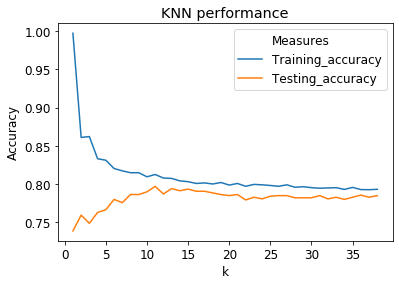

In [600]:
plt.title('KNN performance')
knn_plot = sns.lineplot(x="k", y="Accuracy", hue="Measures",
             data=KNN_result.melt('k', var_name='Measures',  value_name='Accuracy'))

By using different nearest neighbors in the KNN algorithm, we can find the best value to produce the largest testing accuracy.

In [282]:
best_KNN_result = KNN_result[KNN_result.Testing_accuracy == max(test_accuracy)]
best_KNN_k = int(best_KNN_result.k)
best_KNN_result

,k,Training_accuracy,Testing_accuracy
10,11,0.812567,0.797019


In [283]:
print(classification_report(y_test, knn_fit[best_KNN_k-1].predict(x_test), target_names=target_names))

              precision    recall  f1-score   support

          No       0.82      0.92      0.87      1028
         Yes       0.68      0.46      0.55       381

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



# Decision Tree Classifiers
A decision tree is a decision support tool that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.


In [193]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

In [194]:
dtc.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [195]:
dtc_trainng_predict = dtc.predict(x_train)
dtc_test_predict = dtc.predict(x_test)

In [196]:
print('Training accuracy: %.3f \nTesting  accuracy: %.3f' 
      % (accuracy(y_train, dtc_trainng_predict),accuracy(y_test, dtc_test_predict)))

Training accuracy: 0.997 
Testing  accuracy: 0.744


By default without any settings, while we call the decision tree, the model will try to fit the training data without limitations until the optimal training result. Therefore, the model will build a huge tree which can cover all the details and scenarios from the training data. 

This leads to overfitting of the training model. We can clearly see that the training accuracy is 99.7%, which is much higher than the accuracy on predicting the testing data (74.4%). This tells us that we need to do some limitations on the tree size in order to prevent the model overfit our data.

The following part investigates how the maximum depth limitations affect the training and testing performance and hence suggests the best setting for the model.

In [197]:
dep= range(1,39)
dtc_list = list(DecisionTreeClassifier(max_depth=i) for i in range(1,39))
dtc_fit_list = list(dtc.fit(x_train,y_train) for dtc in dtc_list)

dtc_trainng_predict_list = list(dtc.predict(x_train) for dtc in dtc_fit_list)
dtc_testing_predict_list = list(dtc.predict(x_test) for dtc in dtc_fit_list)

In [198]:
dtc_training_acc = list(accuracy(y_train, result) for result in dtc_trainng_predict_list )
dtc_testing_acc = list(accuracy(y_test, result) for result in dtc_testing_predict_list )

In [199]:
dtc_result = pd.DataFrame({'Max_dep':dep,'Training_accuracy':dtc_training_acc,'Testing_accuracy':dtc_testing_acc})

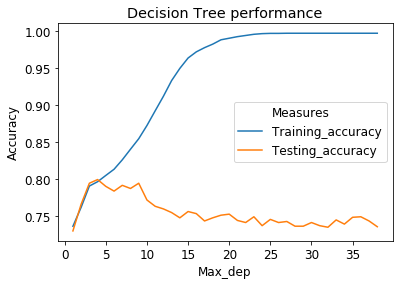

In [200]:
plt.title('Decision Tree performance')
DecisionTree_plot = sns.lineplot(x="Max_dep", y="Accuracy", hue="Measures",
             data=dtc_result.melt('Max_dep', var_name='Measures',  value_name='Accuracy'))

In [201]:
best_dtc_result = dtc_result[dtc_result.Testing_accuracy == max(dtc_result.Testing_accuracy)]
best_dtc_result

,Max_dep,Training_accuracy,Testing_accuracy
3,4,0.796237,0.799148


### Draw the tree
We can visualise the tree by using export_graphviz in sklearn library.

In [202]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtc_list[3], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               class_names=['Not Churn','Churn'],
               feature_names=x_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
draw_tree = Image(graph.create_png())

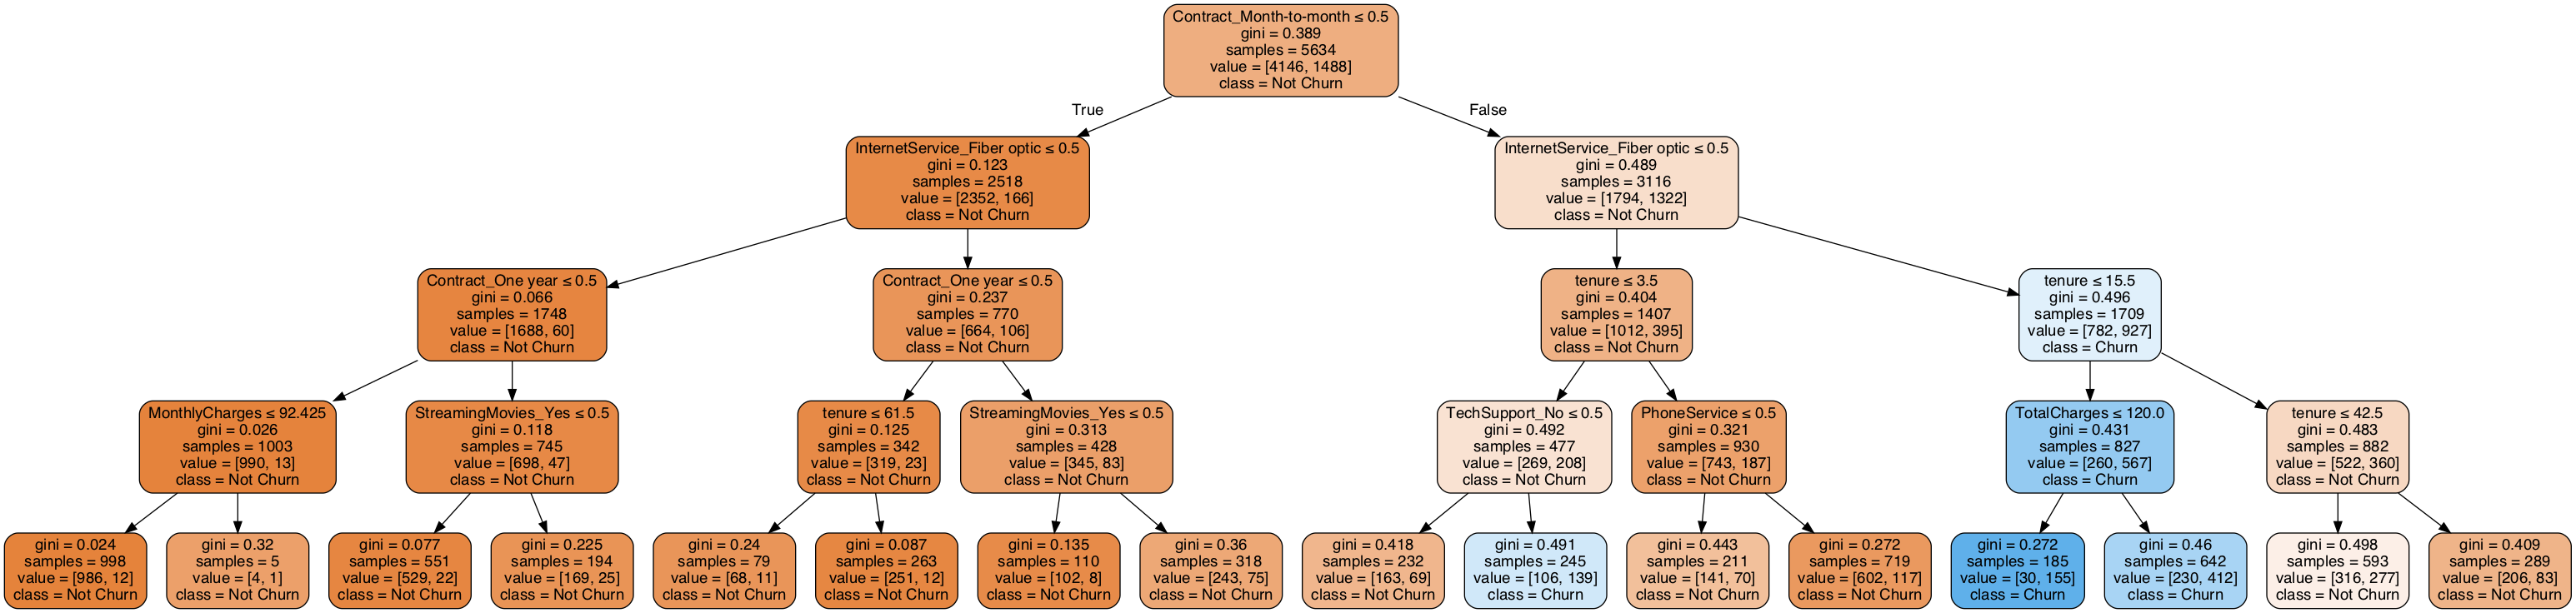

In [203]:
draw_tree

# Random Forest
Random forest is built by repeating the decision tree algorithm but with random bags of features selected in each of the trees instead of all features used during the decision tree algorithm. In this way, we can avoid the decision tree overfitting by only some of the features.

Similar to the decision tree, we can set different values of maximum depth and find the optimum depth out.

In [481]:
from sklearn.ensemble import RandomForestClassifier

In [496]:
%%time
dep = []
rf_classifier = []
rf_train_accuracy = []
rf_test_accuracy = []

for max_dep in range(1,39):
    dep.append(max_dep)
    randomForest = RandomForestClassifier(max_depth=max_dep)
    randomForest.fit(x_train, y_train)
    rf_classifier.append(randomForest)
    rf_trainng_predict = randomForest.predict(x_train)
    rf_test_predict = randomForest.predict(x_test)
    rf_train_accuracy.append(accuracy(y_train, rf_trainng_predict))
    rf_test_accuracy.append(accuracy(y_test, rf_test_predict))

CPU times: user 3.13 s, sys: 111 ms, total: 3.24 s
Wall time: 3.77 s


In [497]:
rf_result = pd.DataFrame({'Max_dep':dep,'Training_accuracy':rf_train_accuracy,'Testing_accuracy':rf_test_accuracy})

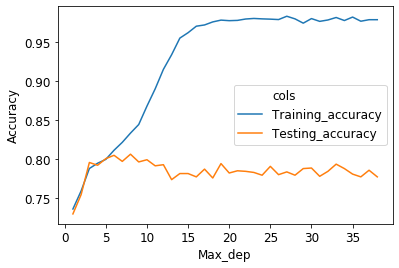

In [498]:
plt.title('Random Forest performance')
ax = sns.lineplot(x="Max_dep", y="Accuracy", hue="Measures",
                  data=rf_result.melt('Max_dep', var_name='Measures',  value_name='Accuracy'))

In [499]:
best_rf_result = rf_result[rf_result.Testing_accuracy == max(rf_result.Testing_accuracy)]
best_rf_dep = int(best_rf_result.Max_dep)
best_rf_result

,Max_dep,Training_accuracy,Testing_accuracy
7,8,0.833333,0.806246


In [500]:
print(classification_report(y_test, rf_classifier[best_dep-1].predict(x_test), target_names=target_names))

              precision    recall  f1-score   support

          No       0.82      0.90      0.86      1028
         Yes       0.65      0.48      0.55       381

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



# Model Comparison
Let's summarise all the models we have developed, together with their training and testing accuracy.

In [543]:
model_performance = pd.DataFrame(columns=['model','Training_accuracy','Testing_accuracy'])

model_performance.loc[len(model_performance)] = ['Ramdon Forest with max depth '+str(best_rf_dep)] + list(best_rf_result.reset_index().iloc[0,2:4])
model_performance.loc[len(model_performance)] = ['Decision Tree with max depth '+str(best_dtc_result.reset_index().iloc[0,1])] + list(best_dtc_result.reset_index().iloc[0,2:4])
model_performance.loc[len(model_performance)] = ['KNN with k='+str(best_KNN_result.reset_index().iloc[0,1])] + list(best_KNN_result.reset_index().iloc[0,2:4])
model_performance.loc[len(model_performance)] = ['Logistic Regression'] + [accuracy(y_train, LR_pred_train),accuracy(y_test, LR_pred_test)]
model_performance = pd.concat([model_performance,svc_performance],ignore_index=True)
model_performance = model_performance.sort_values('Testing_accuracy',ascending = False).reset_index(drop= True)

In [544]:
model_performance

,model,Training_accuracy,Testing_accuracy
0,Ramdon Forest with max depth 8,0.833333,0.806246
1,Logistic Regression,0.806887,0.804116
2,SVC with linear kernel,0.796237,0.801987
3,Decision Tree with max depth 4,0.796237,0.799148
4,KNN with k=11,0.812567,0.797019
5,SVC with RBF kernel (auto gamma),0.908946,0.775018
6,SVC with polynomial kernel (degree = 2),0.766951,0.755145
7,SVC with sigmoid kernel,0.735889,0.729595


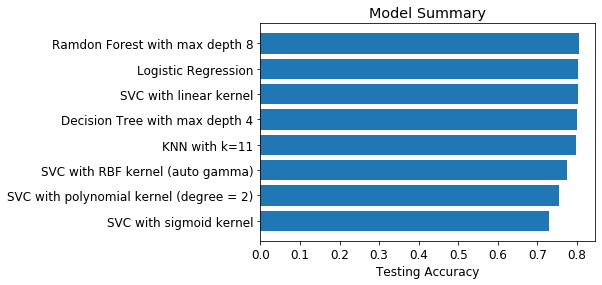

In [540]:
plt.barh(model_performance.model,model_performance.Testing_accuracy)
plt.title('Model Summary')
plt.xlabel('Testing Accuracy')

plt.gca().invert_yaxis()

Random Forest gives the best performance to predict customer churn among all models with testing accuracy 80.6%.

# Conclusion

In this project, we have explored the customer churn data and built several models to classify whether will the customers discontinue the telecom service. From the first part (EDA), we found the top factors driving the customers churn are the contract status and tenure length. In the second part (Predictive Modelling), we are able to predict the customers who would potentially terminate the service with an accuracy of 80.6% by using random forest classification.